In [10]:
import cv2
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
img = cv2.imread("images\\the_berry_farms_sunflower_field.jpeg",0) #gray scale conversion
from scipy import ndimage
from scipy.ndimage import filters
from scipy import spatial
k = 1.414
sigma = 1.0
img = img/255.0  #image normalization

In [11]:
def LoG(sigma):
    #window size 
    n = np.ceil(sigma*6)
    y,x = np.ogrid[-n//2:n//2+1,-n//2:n//2+1]
    y_filter = np.exp(-(y*y/(2.*sigma*sigma)))
    x_filter = np.exp(-(x*x/(2.*sigma*sigma)))
    final_filter = (-(2*sigma**2) + (x*x + y*y) ) *  (x_filter*y_filter) * (1/(2*np.pi*sigma**4))
    return final_filter

In [12]:
def LoG_convolve(img):
    log_images = [] #to store responses
    for i in range(0,9):
        y = np.power(k,i) 
        sigma_1 = sigma*y #sigma 
        filter_log = LoG(sigma_1) #filter generation
        image = cv2.filter2D(img,-1,filter_log) # convolving image
        image = np.pad(image,((1,1),(1,1)),'constant') #padding 
        image = np.square(image) # squaring the response
        log_images.append(image)
    log_image_np = np.array([i for i in log_images]) # storing the #in numpy array
    return log_image_np
log_image_np = LoG_convolve(img)
print(log_image_np.shape)

(9, 1442, 1442)


In [13]:
def detect_blob(log_image_np):
    co_ordinates = [] #to store co ordinates
    (h,w) = img.shape
    for i in range(1,h):
        for j in range(1,w):
            slice_img = log_image_np[:,i-1:i+2,j-1:j+2] #9*3*3 slice
            result = np.amax(slice_img) #finding maximum
            if result >= 0.05: #threshold
                z,x,y = np.unravel_index(slice_img.argmax(),slice_img.shape)
                co_ordinates.append((i+x-1,j+y-1,k**z*sigma)) #finding co-rdinates
    return co_ordinates
co_ordinates = list(set(detect_blob(log_image_np)))

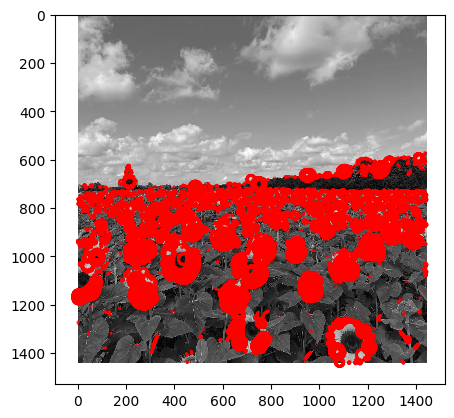

In [14]:
fig, ax = plt.subplots()
nh,nw = img.shape
count = 0


ax.imshow(img, interpolation='nearest',cmap="gray")
for blob in co_ordinates:
    y,x,r = blob
    c = plt.Circle((x, y), r*1.414, color='red', linewidth=1.5, fill=False)
    ax.add_patch(c)
ax.plot()  
plt.show()

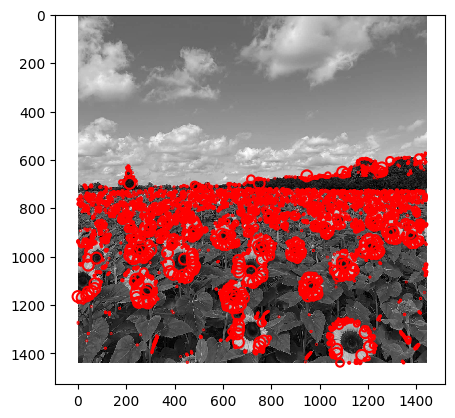

In [15]:
import math

def is_overlapping(blob1, blob2, threshold=0.5):
    """Check if two blobs overlap based on their distance and radius."""
    x1, y1, r1 = blob1
    x2, y2, r2 = blob2
    distance = math.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    return distance < (r1 + r2) * threshold

def remove_overlapping_blobs(co_ordinates, overlap_threshold=0.5):
    """Remove blobs that overlap, keeping only the larger blob."""
    non_overlapping_blobs = []
    co_ordinates.sort(key=lambda b: b[2], reverse=True)  # Sort by radius in descending order

    while co_ordinates:
        current_blob = co_ordinates.pop(0)
        non_overlapping_blobs.append(current_blob)
        co_ordinates = [b for b in co_ordinates if not is_overlapping(current_blob, b, overlap_threshold)]

    return non_overlapping_blobs

# Remove overlapping blobs
filtered_blobs = remove_overlapping_blobs(co_ordinates)

# Re-plotting the blobs without overlap
fig, ax = plt.subplots()
nh, nw = img.shape

ax.imshow(img, interpolation='nearest', cmap="gray")
for blob in filtered_blobs:
    y, x, r = blob
    c = plt.Circle((x, y), r * 1.414, color='red', linewidth=1.5, fill=False)
    ax.add_patch(c)
ax.plot()
plt.show()
